In [1]:
import pandas as pd
from sklearn.utils import shuffle
import numpy as np
import string
from sklearn.decomposition import PCA
from string import punctuation
import datetime
import time
from sklearn.metrics import f1_score, classification_report, accuracy_score,confusion_matrix

from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
color = sns.color_palette()
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import plotly.tools as tls


from gensim.models import KeyedVectors
from gensim.models import Word2Vec

from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, Callback, ReduceLROnPlateau
from keras.models import load_model, Model

Using TensorFlow backend.


In [2]:
df_train = pd.read_csv("train_data_restaurant.tsv", delimiter='\t', header=None)
df_train= shuffle(df_train)
df_train

,0,1
101,Kecewa dengan pelayanan nya. Menunggu 3 makana...,negative
372,Tiba-tiba teringat ingin makan Cah Kangkung di...,negative
1238,Bagi anda2 yg sedang berwisata ke kota bandung...,positive
1609,Mampir ke Bandung. nyari-nyari ramen. yang kat...,positive
289,Dari namanya tentunya diharapkan untuk datang ...,negative
...,...,...
235,waktu itu gw coba steaknya gw ga nyangka bakal...,negative
1276,"Jika anda ke bandung, makanan sunda ? Ya rumah...",positive
1495,Paris Van Java adalah mall besar dengan sekian...,positive
1641,"Nasi goreng tahu udang sangat enak sekali euy,...",positive


1780


positive    1200
negative     580
Name: 1, dtype: int64

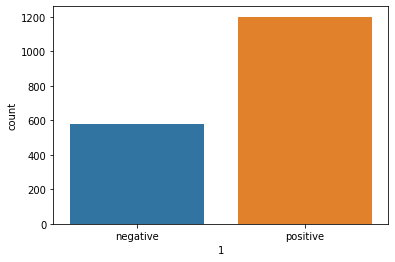

In [3]:
y_train = df_train[1]
print(len(y_train))
sns.countplot(y_train)
y_train.value_counts()

In [4]:
df_test = pd.read_csv("test_data_restaurant.tsv", delimiter='\t', header=None)
df_test=shuffle(df_test)
df_test

,0,1
13,Kebetulan dekat tempat menginap di asia afrika...,negative
40,Kalo suasananya sih oke di sana masih asri ban...,negative
60,"Kalau mendengar dari namanya, siapa yg tidak t...",negative
177,"Salmon, tuna, dll nya segar, kualitasnya sanga...",positive
86,"Resto didesain menarik, di lantai 1 ada area m...",positive
...,...,...
33,kurang matang ayam vietnamnya. lebih baik dice...,negative
145,Tempatnya ok. pemandangan bagus. makanan enak ...,positive
131,"non halal, khas bandung sekali. citarasa jadul...",positive
15,"Batagornya enak, tapi bila diukur dengan harga...",negative


185


positive    120
negative     65
Name: 1, dtype: int64

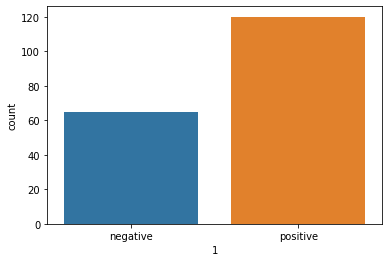

In [5]:
y_test = df_test[1]
print(len(y_test))
sns.countplot(y_test)
y_test.value_counts()

In [6]:
#preprocessing

white_list = string.ascii_letters + string.digits+' '
white_list

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 '

In [7]:

def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
#     sentences=str(sentences)
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [8]:
list_train = list(df_train[0])
char = build_vocab(list_train)

In [9]:
symbols = ''.join([c for c in char if not c in white_list])
print(symbols)

.-,()+"'!/:&?%><$~@_*;[]=^#


In [10]:
isolate_dict = {ord(c):f' {c} ' for c in symbols}

In [11]:
df_train_x_clean = df_train[0].apply(lambda x: x.translate(isolate_dict))
df_test_x_clean = df_test[0].apply(lambda x: x.translate(isolate_dict))

In [12]:
#clean word and normalization
kamus = open("kamus_alay.txt").read().split("\n")
kamus

['anakjakartaasikasik,anak jakarta asyik asyik',
 'pakcikdahtua,pak cik sudah tua',
 'pakcikmudalagi,pak cik muda lagi',
 't3tapjokowi,tetap jokowi',
 '3x,tiga kali',
 'aamiin,amin',
 'aamiinn,amin',
 'aamin,amin',
 'aammiin,amin',
 'abis,habis',
 'abisin,habiskan',
 'acau,kacau',
 'achok,ahok',
 'ad,ada',
 'adek,adik',
 'adl,adalah',
 'adlah,adalah',
 'adlh,adalah',
 'ado,ada',
 'aduhh,aduh',
 'aer,air',
 'afdol,afdal',
 'agamaataualqur,agama alquran',
 'agm,agama',
 'agma,agama',
 'ahaha,haha',
 'ahahaha,haha',
 'ahehehehe,hehe',
 'ahir,akhir',
 'ahirnya,akhirnya',
 'ahk,ahok',
 'ahlamdulillah,alhamdulillah',
 'ahli2,para ahli',
 'ahlusunnah,ahlus sunah',
 'ahmaddani,ahmad dhani',
 'aho,ahok',
 'ahoax,ahok',
 'ahoaxx,ahok',
 'ahog,ahok',
 'ahokataudjarot,ahok djarot',
 'ahokbebanijokowi,ahok beban jokowi',
 'ahokbtp,ahok basuki tjahaja purnama',
 'ahokditolakwarga,ahok ditolak warga',
 'ahokdjarot,ahok djarot',
 'ahokdjarotterbukti,ahok djarot terbukti',
 'ahokers,ahoker',
 'ahokfigh

In [13]:
dict_alay = {}
for i in kamus:
    split_kamus = i.split(',')
    dict_alay[split_kamus[0]] = split_kamus[1]
dict_alay

{'anakjakartaasikasik': 'anak jakarta asyik asyik',
 'pakcikdahtua': 'pak cik sudah tua',
 'pakcikmudalagi': 'pak cik muda lagi',
 't3tapjokowi': 'tetap jokowi',
 '3x': 'tiga kali',
 'aamiin': 'amin',
 'aamiinn': 'amin',
 'aamin': 'amin',
 'aammiin': 'amin',
 'abis': 'habis',
 'abisin': 'habiskan',
 'acau': 'kacau',
 'achok': 'ahok',
 'ad': 'ada',
 'adek': 'adik',
 'adl': 'adalah',
 'adlah': 'adalah',
 'adlh': 'adalah',
 'ado': 'ada',
 'aduhh': 'aduh',
 'aer': 'air',
 'afdol': 'afdal',
 'agamaataualqur': 'agama alquran',
 'agm': 'agama',
 'agma': 'agama',
 'ahaha': 'haha',
 'ahahaha': 'haha',
 'ahehehehe': 'hehe',
 'ahir': 'akhir',
 'ahirnya': 'akhirnya',
 'ahk': 'ahok',
 'ahlamdulillah': 'alhamdulillah',
 'ahli2': 'para ahli',
 'ahlusunnah': 'ahlus sunah',
 'ahmaddani': 'ahmad dhani',
 'aho': 'ahok',
 'ahoax': 'ahok',
 'ahoaxx': 'ahok',
 'ahog': 'ahok',
 'ahokataudjarot': 'ahok djarot',
 'ahokbebanijokowi': 'ahok beban jokowi',
 'ahokbtp': 'ahok basuki tjahaja purnama',
 'ahokditolakw

In [14]:
def normal (x):
    x_split = x.lower().split()
    k = []
    for i in x_split:
        if i in dict_alay.keys():
            k.append(dict_alay[i])
        else:
            k.append(i)
    return " ".join(k)
df_train_x_clean2 = df_train_x_clean.apply(normal)
df_test_x_clean2 = df_test_x_clean.apply(normal)

In [15]:

print(punctuation)
df_train_x_clean2 = df_train_x_clean2.apply(lambda x : ''.join([c for c in x if c not in punctuation]))
df_test_x_clean2 = df_test_x_clean2.apply(lambda x : ''.join([c for c in x if c not in punctuation]))

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [16]:
#make word2vec

data = df_train_x_clean2.apply(lambda x : x.split())
sentences = list(data)
# train model
model = Word2Vec(sentences,min_count=2)
# summarize the loaded model
print(model)
# summarize vocabulary
words = list(model.wv.vocab)
print(words)
# access vector for one word
print(model[model.wv.vocab])
# save model
model.save('model.bin')
# load model
new_model = Word2Vec.load('model.bin')
print(new_model)

Word2Vec(vocab=3158, size=100, alpha=0.025)
['kecewa', 'dengan', 'pelayanan', 'nya', 'menunggu', '3', 'makanan', 'waktu', 'hampir', '1', 'jam', 'sangat', 'dan', 'tidak', 'akan', 'datang', 'lagi', 'untuk', 'ke', 'dua', 'kali', 'tiba', 'teringat', 'ingin', 'makan', 'cah', 'kangkung', 'di', 'bandung', 'saya', 'mendapatkan', 'restoran', 'ini', 'setelah', 'pulang', 'kantor', 'kami', 'ujung', 'jalan', 'kebun', 'kawung', 'sederhana', 'saja', 'tanpa', 'ac', 'ketika', 'melihat', 'daftar', 'harganya', 'langsung', 'kaget', 'juga', 'spesial', 'daging', 'sapi', 'telur', 'puyuh', 'dihargai', 'rupiah', '90', '000', 'wah', 'mahal', 'sekali', 'bagi', 'yang', 'sedang', 'berwisata', 'kota', 'jangan', 'melewati', 'tempat', 'lokasinya', 'percis', 'braga', 'hanya', 'parkiran', 'mobil', 'sedikit', 'sulit', 'tertentu', 'anda', 'menyukai', 'sini', 'bisa', 'jadikan', 'momen', 'berfoto', 'selain', 'itu', 'minum', 'sajikan', 'mengingat', 'seperti', 'gaya', 'gedung', 'mampir', 'mencari', 'ramen', 'katanya', 'kekin

/opt/anaconda3/envs/tf_env/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



/opt/anaconda3/envs/tf_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



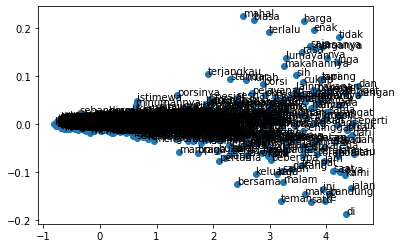

In [17]:

X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [18]:
#make word index

tokenizer = Tokenizer(num_words=2000,oov_token='<OOV>')
tokenizer.fit_on_texts(list(df_train_x_clean2))
word_index = tokenizer.word_index
word_index


{'<OOV>': 1,
 'yang': 2,
 'dan': 3,
 'di': 4,
 'saya': 5,
 'tidak': 6,
 'dengan': 7,
 'enak': 8,
 'untuk': 9,
 'ini': 10,
 'makan': 11,
 'makanan': 12,
 'juga': 13,
 'tempat': 14,
 'ada': 15,
 'nya': 16,
 'sangat': 17,
 'menu': 18,
 'cukup': 19,
 'ke': 20,
 'sini': 21,
 'rasa': 22,
 'harga': 23,
 'karena': 24,
 'dari': 25,
 'bandung': 26,
 'kami': 27,
 'banyak': 28,
 'tapi': 29,
 'saja': 30,
 'rasanya': 31,
 'banget': 32,
 'bisa': 33,
 'sudah': 34,
 'kurang': 35,
 'kalau': 36,
 'tempatnya': 37,
 'restoran': 38,
 'biasa': 39,
 'ayam': 40,
 'jadi': 41,
 'datang': 42,
 'jalan': 43,
 'lebih': 44,
 'teman': 45,
 'goreng': 46,
 'adalah': 47,
 'buat': 48,
 'sekali': 49,
 'nasi': 50,
 'lumayan': 51,
 'nyaman': 52,
 'makanannya': 53,
 'lagi': 54,
 'itu': 55,
 'terlalu': 56,
 'sama': 57,
 'mahal': 58,
 'lain': 59,
 'harganya': 60,
 'seperti': 61,
 'pesan': 62,
 'satu': 63,
 'atau': 64,
 'kita': 65,
 'suka': 66,
 'steak': 67,
 'saat': 68,
 'hanya': 69,
 'pilihan': 70,
 'sih': 71,
 'pas': 72,
 'ag

In [19]:
#preparing embedding

new_model
print('Found %s word vectors of word2vec' % len(new_model.wv.vocab))

Found 3158 word vectors of word2vec


In [20]:
print('Preparing embedding matrix')
words_in_word2vec = new_model.wv.vocab
nb_words = len(word_index) + 1
embedding_matrix = np.zeros((nb_words, 100))
for word, i in word_index.items():
    if word in words_in_word2vec:
        embedding_matrix[i] = new_model[word]
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

print(embedding_matrix)

Preparing embedding matrix
Null word embeddings: 3329
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.26684058 -0.1671866   0.20753352 ...  0.97894192  0.67133969
   0.65322304]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


/opt/anaconda3/envs/tf_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



In [21]:
#pad sequences

X_train = tokenizer.texts_to_sequences(data)
X_train = sequence.pad_sequences(X_train, padding='post', truncating='post',maxlen=60)
X_test = tokenizer.texts_to_sequences(df_test_x_clean2)
X_test = sequence.pad_sequences(X_test, padding='post', truncating='post',maxlen=60)

In [22]:
y_train = df_train[1].apply(lambda x : 1 if x =='positive' else 0)
y_test =df_test[1].apply(lambda x : 1 if x =='positive' else 0)

In [23]:
y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values

In [26]:
#build model


embed_dim = 100
max_features = 2000
max_len = 60
batch_size = 32
words = len(word_index)+1

# model_input = Input(shape=(max_len,), dtype='int32')
# model_embed = Embedding(len(word_index)+1, embed_dim,input_length=max_len)(model_input)
# model_dl = (LSTM(128, dropout=0.2, recurrent_dropout=0.2))(model_embed)
# model_output = (Dense(1, activation='sigmoid'))(model_dl)
# model = Model ([model_input], [model_output])

model = Sequential()
model.add(Embedding(words,embed_dim, weights = [embedding_matrix], mask_zero=True))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))  # 100 memory
model.add(Dense(units=2,activation='softmax'))

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()
print('Train...')
best_train = 'train_model_using_word2vec.h5'
mcp_save = ModelCheckpoint(best_train, save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=15,
          validation_data=[X_test,y_test],
         callbacks=[mcp_save,reduce_lr_loss])



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         648700    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 766,206
Trainable params: 766,206
Non-trainable params: 0
_________________________________________________________________
Train...


/opt/anaconda3/envs/tf_env/lib/python3.7/site-packages/keras/callbacks/callbacks.py:998: UserWarning:

`epsilon` argument is deprecated and will be removed, use `min_delta` instead.

/opt/anaconda3/envs/tf_env/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 1780 samples, validate on 185 samples
Epoch 1/15
1780/1780 [==============================] - 5s 3ms/step - loss: 0.6452 - accuracy: 0.6657 - val_loss: 0.6435 - val_accuracy: 0.6486
Epoch 2/15
1780/1780 [==============================] - 4s 2ms/step - loss: 0.6063 - accuracy: 0.6787 - val_loss: 0.6101 - val_accuracy: 0.6486
Epoch 3/15
1780/1780 [==============================] - 4s 2ms/step - loss: 0.4724 - accuracy: 0.7618 - val_loss: 0.3685 - val_accuracy: 0.8595
Epoch 4/15
1780/1780 [==============================] - 4s 2ms/step - loss: 0.3393 - accuracy: 0.8449 - val_loss: 0.3742 - val_accuracy: 0.8432
Epoch 5/15
1780/1780 [==============================] - 4s 2ms/step - loss: 0.2687 - accuracy: 0.8876 - val_loss: 0.3682 - val_accuracy: 0.8486
Epoch 6/15
1780/1780 [==============================] - 4s 2ms/step - loss: 0.1815 - accuracy: 0.9253 - val_loss: 0.4574 - val_accuracy: 0.8432
Epoch 7/15
1780/1780 [==============================] - 4s 2ms/step - loss: 0.1487 - accu

In [27]:
model_prediction = load_model(best_train)
score, acc = model_prediction.evaluate(X_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

/opt/anaconda3/envs/tf_env/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



185/185 [==============================] - 0s 1ms/step
Test score: 0.36819922440760844
Test accuracy: 0.8486486673355103


In [28]:
#evaluasi
pred = model_prediction.predict(X_test)
y_test_1 =df_test[1].apply(lambda x : 1 if x =='positive' else 0)
preds = np.array([np.argmax(pr) for pr in pred])
correct = np.sum(preds==y_test_1)
print ("Correctly Predicted : ", correct,"/",len(y_test_1))
print ("Accuracy : ", correct*100.0/len(y_test_1))
print(confusion_matrix(preds, y_test_1))
print(classification_report(preds, y_test_1))

Correctly Predicted :  157 / 185
Accuracy :  84.86486486486487
[[ 42   5]
 [ 23 115]]
              precision    recall  f1-score   support

           0       0.65      0.89      0.75        47
           1       0.96      0.83      0.89       138

    accuracy                           0.85       185
   macro avg       0.80      0.86      0.82       185
weighted avg       0.88      0.85      0.86       185

